In [5]:
!pip install keras-utils

In [6]:
!pip install keras-utils

In [12]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator,load_img
#from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

In [15]:
Image_width=128
Image_height=128
Image_size=(Image_width,Image_height)
Image_channels=3

In [18]:
from tensorflow.keras.utils import to_categorical

In [19]:
from google.colab import drive

In [20]:
drive.mount("/content/drive")

Mounted at /content/drive


In [21]:
classes = os.listdir("../content/drive/MyDrive/flowers")
classes

['daisy', 'dandelion', 'sunflower', 'rose', 'tulip']

In [28]:
batch_size=32
image_size = (128, 128)

In [24]:
import tensorflow as tf

In [29]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../content/drive/MyDrive/flowers",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode="categorical",
    class_names=classes
)


Found 4317 files belonging to 5 classes.
Using 3454 files for training.


In [30]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../content/drive/MyDrive/flowers",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode="categorical",
    class_names=classes
)

Found 4317 files belonging to 5 classes.
Using 863 files for validation.


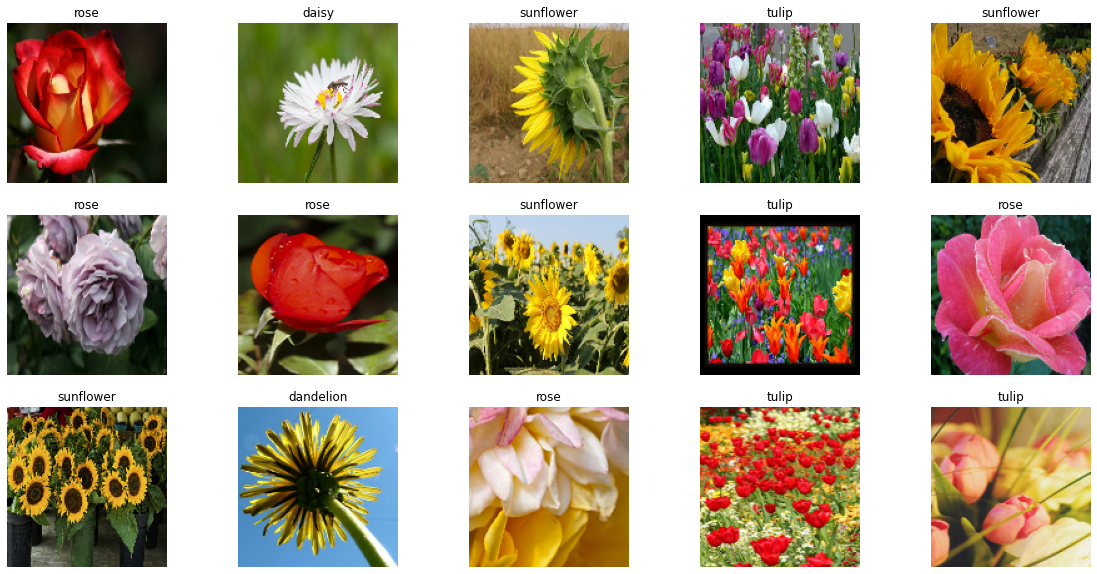

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
for images, labels in train_ds.take(1):
    for i in range(15):
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes[np.argmax(labels[i])])
        plt.axis("off")
plt.show()

In [32]:
from tensorflow.keras.applications.resnet import ResNet101

from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization


In [33]:
base_model = ResNet101(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(len(classes), activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=["accuracy"],)

171450368/171446536 [==============================] - 1s 0us/step


In [34]:

history = model.fit(train_ds, epochs=30, validation_data=val_ds)

Epoch 1/30
108/108 [==============================] - 495s 4s/step - loss: 0.8130 - accuracy: 0.7409 - val_loss: 0.7078 - val_accuracy: 0.7879
Epoch 2/30
108/108 [==============================] - 16s 148ms/step - loss: 0.5055 - accuracy: 0.8263 - val_loss: 0.5134 - val_accuracy: 0.8447
Epoch 3/30
108/108 [==============================] - 16s 144ms/step - loss: 0.3694 - accuracy: 0.8709 - val_loss: 0.6081 - val_accuracy: 0.8181
Epoch 4/30
108/108 [==============================] - 16s 146ms/step - loss: 0.2896 - accuracy: 0.9027 - val_loss: 0.5720 - val_accuracy: 0.8262
Epoch 5/30
108/108 [==============================] - 16s 146ms/step - loss: 0.2135 - accuracy: 0.9233 - val_loss: 0.5357 - val_accuracy: 0.8482
Epoch 6/30
108/108 [==============================] - 17s 153ms/step - loss: 0.1770 - accuracy: 0.9343 - val_loss: 0.6190 - val_accuracy: 0.8273
Epoch 7/30
108/108 [==============================] - 17s 149ms/step - loss: 0.1478 - accuracy: 0.9493 - val_loss: 0.6160 - val_accu

In [35]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

xepochs = [n for n in range(len(history.history['accuracy']))]

fig = make_subplots(rows=1, cols=2, subplot_titles=("Accuracy over time", "Loss over time"))

for metric in ['accuracy', 'val_accuracy']:
    fig.add_trace(go.Scatter(x=xepochs, y=history.history[metric], mode='lines+markers', name=metric), row=1, col=1)

for metric in ['loss', 'val_loss']:
    fig.add_trace(go.Scatter(x=xepochs, y=history.history[metric], mode='lines+markers', name=metric), row=1, col=2)

fig.update_xaxes(title_text="Epoch", row=1, col=1)
fig.update_xaxes(title_text="Epoch", row=1, col=2)

fig.update_yaxes(title_text="Accuracy", row=1, col=1)
fig.update_yaxes(title_text="Loss", row=1, col=2)

fig.show()

In [36]:
predictions = model.predict(val_ds)
labels = tf.concat([y for [_, y] in val_ds], axis=0).numpy()

In [37]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(np.argmax(labels, axis=1), np.argmax(predictions, axis=1))

In [39]:
from sklearn.metrics import classification_report

print(classification_report(
    np.argmax(labels, axis=1), 
    np.argmax(predictions, axis=1),
    target_names=classes
))

              precision    recall  f1-score   support

       daisy       0.15      0.12      0.14       137
   dandelion       0.25      0.25      0.25       234
   sunflower       0.15      0.15      0.15       150
        rose       0.17      0.17      0.17       151
       tulip       0.21      0.24      0.22       191

    accuracy                           0.20       863
   macro avg       0.19      0.19      0.19       863
weighted avg       0.19      0.20      0.19       863



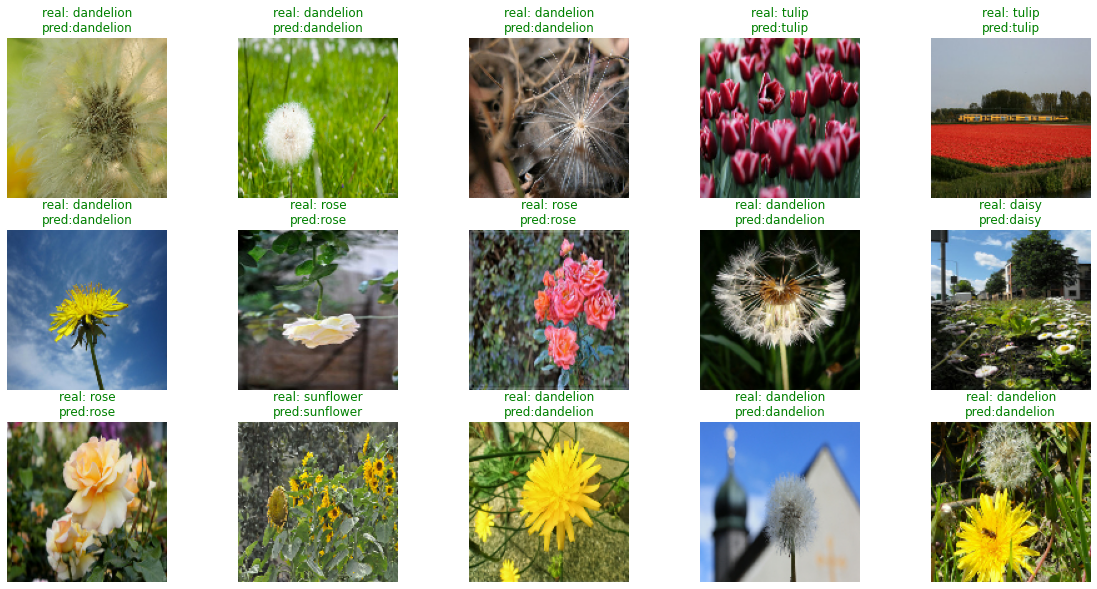

In [40]:
plt.figure(figsize=(20, 10))
for images, labels in val_ds.take(1):
    for i in range(15):
        ax = plt.subplot(3, 5, i + 1)
        
        img_array = images[i].numpy().astype("uint8")
        prediction = model.predict(np.array([img_array]))
        prediction_name = classes[np.argmax(prediction)]
        real_name = classes[np.argmax(labels[i])]
        
        plt.imshow(img_array)
        if prediction_name == real_name:
            plt.title(f'real: {real_name}\npred:{prediction_name}', fontdict={'color': 'g'})
        else:
            plt.title(f'real: {real_name}\npred:{prediction_name}', fontdict={'color': 'r'})
        
        plt.axis("off")